In [1]:
from IPython.display import Image

# CNTK 101: Logistic Regression and ML Primer

This tutorial is targeted to individuals who are new to CNTK and to machine learning. In this tutorial, you will train a simple yet powerful machine learning model that is widely used in industry for a variety of applications. The model trained below scales to massive data sets in the most expeditious manner by harnessing computational scalability leveraging the computational resources you may have (one or more CPU cores, one or more GPUs, a cluster of CPUs or a cluster of GPUs), transparently via the CNTK library.

The following notebook uses Python APIs. If you are looking for this example in BrainScript, please look [here](https://github.com/Microsoft/CNTK/tree/v2.0/Tutorials/HelloWorld-LogisticRegression). 

## Introduction

**Problem**:
A cancer hospital has provided data and wants us to determine if a patient has a fatal [malignant][] cancer vs. a benign growth. This is known as a classification problem. To help classify each patient, we are given their age and the size of the tumor. Intuitively, one can imagine that younger patients and/or patients with small tumors are less likely to have a malignant cancer. The data set simulates this application: each observation is a patient represented as a dot (in the plot below), where red indicates malignant and blue indicates benign. Note: This is a toy example for learning; in real life many features from different tests/examination sources and the expertise of doctors would play into the diagnosis/treatment decision for a patient.
[malignant]: https://en.wikipedia.org/wiki/Malignancy

In [2]:
# Figure 1
Image(url="https://www.cntk.ai/jup/cancer_data_plot.jpg", width=400, height=400)

**Goal**:
Our goal is to learn a classifier that can automatically label any patient into either the benign or malignant categories given two features (age and tumor size). In this tutorial, we will create a linear classifier, a fundamental building-block in deep networks.

In [3]:
# Figure 2
Image(url= "https://www.cntk.ai/jup/cancer_classify_plot.jpg", width=400, height=400)

In the figure above, the green line represents the model learned from the data and separates the blue dots from the red dots. In this tutorial, we will walk you through the steps to learn the green line. Note: this classifier does make mistakes, where a couple of blue dots are on the wrong side of the green line. However, there are ways to fix this and we will look into some of the techniques in later tutorials. 

**Approach**: 
Any learning algorithm typically has five stages. These are Data reading, Data preprocessing, Creating a model, Learning the model parameters, and Evaluating the model (a.k.a. testing/prediction). 

>1. Data reading: We generate simulated data sets with each sample having two features (plotted below) indicative of the age and tumor size.
>2. Data preprocessing: Often, the individual features such as size or age need to be scaled. Typically, one would scale the data between 0 and 1. To keep things simple, we are not doing any scaling in this tutorial (for details look here: [feature scaling][]).
>3. Model creation: We introduce a basic linear model in this tutorial. 
>4. Learning the model: This is also known as training. While fitting a linear model can be done in a variety of ways ([linear regression][]), in CNTK we use Stochastic Gradient Descent a.k.a. [SGD][].
>5. Evaluation: This is also known as testing, where one evaluates the model on data sets with known labels (a.k.a. ground-truth) that were never used for training. This allows us to assess how a model would perform in real-world (previously unseen) observations.

## Logistic Regression
[Logistic regression][] is a fundamental machine learning technique that uses a linear weighted combination of features and generates the probability of predicting different classes. In our case, the classifier will generate a probability in [0,1] which can then be compared to a threshold (such as 0.5) to produce a binary label (0 or 1). However, the method shown can easily be extended to multiple classes. 
[feature scaling]: https://en.wikipedia.org/wiki/Feature_scaling
[SGD]: https://en.wikipedia.org/wiki/Stochastic_gradient_descent
[linear regression]: https://en.wikipedia.org/wiki/Linear_regression
[logistic regression]: https://en.wikipedia.org/wiki/Logistic_regression
[softmax]: https://en.wikipedia.org/wiki/Multinomial_logistic_regression

In [4]:
# Figure 3
Image(url= "https://www.cntk.ai/jup/logistic_neuron.jpg", width=300, height=200)

In the above figure, contributions from different input features are linearly weighted and aggregated. The resulting sum is mapped to a (0, 1) range via a [sigmoid][] function. For classifiers with more than two output labels, one can use a [softmax][] function.
[sigmoid]: https://en.wikipedia.org/wiki/Sigmoid_function
[softmax]: https://en.wikipedia.org/wiki/Softmax_function

In [5]:
# Import the relevant components
from __future__ import print_function
import numpy as np
import sys
import os

import cntk as C

In the block below, we check if we are running this notebook in the CNTK internal test machines by looking for environment variables defined there. We then select the right target device (GPU vs CPU) to test this notebook. In other cases, we use CNTK's default policy to use the best available device (GPU, if available, else CPU).

In [6]:
# Select the right target device when this notebook is being tested:
if 'TEST_DEVICE' in os.environ:
    if os.environ['TEST_DEVICE'] == 'cpu':
        C.device.try_set_default_device(C.device.cpu())
    else:
        C.device.try_set_default_device(C.device.gpu(0))

## Data Generation
Let us generate some synthetic data emulating the cancer example using the `numpy` library. We have two input features (represented in two-dimensions) and two output classes (benign/blue or malignant/red). 

In our example, each observation (a single 2-tuple of features - age and size) in the training data has a label (blue or red). Because we have two output labels, we call this a binary classification task. 

In [7]:
# Define the network
input_dim = 2
num_output_classes = 2

### Input and Labels

In this tutorial we are generating synthetic data using the `numpy` library. In real-world problems, one would use a [reader][], that would read feature values (`features`: *age* and *tumor size*) corresponding to each observation (patient). The simulated *age* variable is scaled down to have a similar range to that of the other variable. This is a key aspect of data pre-processing that we will learn more about in later tutorials. Note: in general, observations and labels can reside in higher dimensional spaces (when more features or classifications are available) and are then represented as [tensors][] in CNTK. More advanced tutorials introduce the handling of high dimensional data.

[reader]: https://github.com/Microsoft/CNTK/search?p=1&q=reader&type=Wikis&utf8=%E2%9C%93
[tensors]: https://en.wikipedia.org/wiki/Tensor

In [8]:
# Ensure that we always get the same results
np.random.seed(0)

# Helper function to generate a random data sample
def generate_random_data_sample(sample_size, feature_dim, num_classes):
    # Create synthetic data using NumPy. 
    Y = np.random.randint(size=(sample_size, 1), low=0, high=num_classes)

    # Make sure that the data is separable 
    X = (np.random.randn(sample_size, feature_dim)+3) * (Y+1)
    
    # Specify the data type to match the input variable used later in the tutorial 
    # (default type is double)
    X = X.astype(np.float32)    
    
    # convert class 0 into the vector "1 0 0", 
    # class 1 into the vector "0 1 0", ...
    class_ind = [Y==class_number for class_number in range(num_classes)]
    Y = np.asarray(np.hstack(class_ind), dtype=np.float32)
    return X, Y   

In [9]:
# Create the input variables denoting the features and the label data. Note: the input 
# does not need additional info on the number of observations (Samples) since CNTK creates only 
# the network topology first 
mysamplesize = 32
features, labels = generate_random_data_sample(mysamplesize, input_dim, num_output_classes)

Let us visualize the input data.

**Note**: If the import of `matplotlib.pyplot` fails, please run `conda install matplotlib`, which will fix the `pyplot` version dependencies. If you are on a python environment different from Anaconda, then use `pip install matplotlib`.

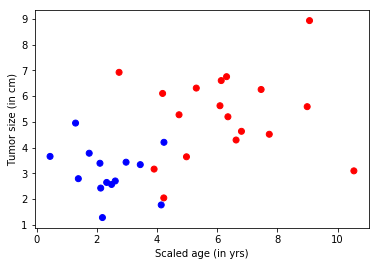

In [10]:
# Plot the data 
import matplotlib.pyplot as plt
%matplotlib inline

# let 0 represent malignant/red and 1 represent benign/blue 
colors = ['r' if label == 0 else 'b' for label in labels[:,0]]

plt.scatter(features[:,0], features[:,1], c=colors)
plt.xlabel("Age (scaled)")
plt.ylabel("Tumor size (in cm)")
plt.show()

# Model Creation

A logistic regression (a.k.a. LR) network is a simple building block, but has powered many ML 
applications in the past decade. LR is a simple linear model that takes as input a vector of numbers describing the properties of what we are classifying (also known as a feature vector, $\bf{x}$, the blue nodes in the figure below) and emits the *evidence* ($z$) (output of the green node, also known as "activation"). Each feature in the input layer is connected to an output node by a corresponding weight $w$ (indicated by the black lines of varying thickness). 

In [11]:
# Figure 4
Image(url= "https://www.cntk.ai/jup/logistic_neuron2.jpg", width=300, height=200)

The first step is to compute the evidence for an observation. 

$$z = \sum_{i=1}^n w_i \times x_i + b = \textbf{w} \cdot \textbf{x} + b$$ 

where $\bf{w}$ is the weight vector of length $n$ and $b$ is known as the [bias][] term. Note: we use **bold** notation to denote vectors. 

The computed evidence is mapped to a (0, 1) range using a `sigmoid` (when the outcome can be in one of two possible classes) or a `softmax` function (when the outcome can be in one of more than two possible classes).

Network input and output: 
- **input** variable (a key CNTK concept): 
>An **input** variable is a user-code-facing container where user-provided code fills in different observations (a data point or sample of data points, equivalent to (age, size) tuples in our example) as inputs to the model function during model learning (a.k.a.training) and model evaluation (a.k.a. testing). Thus, the shape of the `input` must match the shape of the data that will be provided.  For example, if each data point was a grayscale image of height 10 pixels and width 5 pixels, the input feature would be a vector of 50 floating-point values representing the intensity of each of the 50 pixels, and could be written as `C.input_variable(10*5, np.float32)`. Similarly, in our example the dimensions are age and tumor size, thus `input_dim` = 2. More on data and their dimensions to appear in separate tutorials. 

[bias]: https://www.quora.com/What-does-the-bias-term-represent-in-logistic-regression

In [12]:
feature = C.input_variable(input_dim, np.float32)

## Network setup

The `linear_layer` function is a straightforward implementation of the equation above. We perform two operations:
0. multiply the weights ($\bf{w}$)  with the features ($\bf{x}$) using the CNTK `times` operator,
1. add the bias term ($b$).

These CNTK operations are optimized for execution on the available hardware and the implementation hides the complexity away from the user. 

In [13]:
# Define a dictionary to store the model parameters
mydict = {}

def linear_layer(input_var, output_dim):
    
    input_dim = input_var.shape[0]
    weight_param = C.parameter(shape=(input_dim, output_dim))
    bias_param = C.parameter(shape=(output_dim))
    
    mydict['w'], mydict['b'] = weight_param, bias_param

    return C.times(input_var, weight_param) + bias_param

`z` will be used to represent the output of the network.

In [14]:
output_dim = num_output_classes
z = linear_layer(feature, output_dim)

### Learning model parameters

Now that the network is set up, we would like to learn the parameters $\bf w$ and $b$ for our simple linear layer. To do so we convert, the computed evidence ($z$) into a set of predicted probabilities ($\textbf p$) using a `softmax` function.

$$ \textbf{p} = \mathrm{softmax}(z)$$ 

The `softmax` is an activation function that normalizes the accumulated evidence into a probability distribution over the classes (Details of [`softmax`][]). Other choices of activation function can be [here][].

[`softmax`]: https://www.cntk.ai/pythondocs/cntk.ops.html#cntk.ops.softmax

[here]: https://docs.microsoft.com/en-us/cognitive-toolkit/Brainscript-Activation-Functions

## Training
The output of the `softmax` is the probabilities of an observation belonging each of the respective classes. For training the classifier, we need to determine what behavior the model needs to mimic. In other words, we want the generated probabilities to be as close as possible to the observed labels. We can accomplish this by minimizing the difference between our output and the ground-truth labels. This difference is calculated by the *cost* or *loss* function.

[`Cross-entropy`][] is a popular loss function. It is defined as:

$$ H(p) = - \sum_{j=1}^{| \textbf y |} y_j \log (p_j) $$  

where $p$ is our predicted probability from `softmax` function and $y$ is the ground-truth label, provided with the training data. In the two-class example, the `label` variable has two dimensions (equal to the `num_output_classes` or $| \textbf y |$). Generally speaking, the label variable will have $| \textbf y |$ elements with 0 everywhere except at the index of the true class of the data point, where it will be 1.  Understanding the [details][] of the cross-entropy function is highly recommended.

[`cross-entropy`]: http://cntk.ai/pythondocs/cntk.ops.html#cntk.ops.cross_entropy_with_softmax
[details]: http://colah.github.io/posts/2015-09-Visual-Information/

In [15]:
label = C.input_variable(num_output_classes, np.float32)
loss = C.cross_entropy_with_softmax(z, label)

#### Evaluation

In order to evaluate the classification, we can compute the [`classification_error`][], which is 0 if our model was correct (it assigned the true label the most probability), otherwise 1.
[`classification_error`]: https://www.cntk.ai/pythondocs/cntk.metrics.html#cntk.metrics.classification_error

In [16]:
eval_error = C.classification_error(z, label)

### Configure training

The trainer strives to minimize the `loss` function using an optimization technique. In this tutorial, we will use [Stochastic Gradient Descent][] (`sgd`), one of the most popular techniques. Typically, one starts with random initialization of the model parameters (the weights and biases, in our case). For each observation, the `sgd` optimizer can calculate the `loss` or error between the predicted label and the corresponding ground-truth label, and apply [gradient descent][] to generate a new set of model parameters after each observation. 

The aforementioned process of updating all parameters after each observation is attractive because it does not require the entire data set (all observations) to be loaded in memory and also computes the gradient over fewer datapoints, thus allowing for training on large data sets. However, the updates generated using a single observation at a time can vary wildly between iterations. An intermediate ground is to load a small set of observations into the model and use an average of the `loss` or error from that set to update the model parameters. This subset is called a *minibatch*.

With minibatches we often sample observations from the larger training dataset. We repeat the process of updating the model parameters using different combinations of training samples, and over a period of time minimize the `loss` (and the error). When the incremental error rates are no longer changing significantly, or after a preset maximum number of minibatches have been processed, we claim that our model is trained.

One of the key parameters of optimization is the `learning_rate`. For now, we can think of it as a scaling factor that modulates how much we change the parameters in any iteration. We will cover more details in later tutorials. 
With this information, we are ready to create our trainer. 

[optimization]: https://en.wikipedia.org/wiki/Category:Convex_optimization
[Stochastic Gradient Descent]: https://en.wikipedia.org/wiki/Stochastic_gradient_descent
[gradient descent]: http://www.statisticsviews.com/details/feature/5722691/Getting-to-the-Bottom-of-Regression-with-Gradient-Descent.html

In [17]:
# Instantiate the trainer object to drive the model training
learning_rate = 0.5
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch) 
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, eval_error), [learner])

First, let us create some helper functions that will be needed to visualize different functions associated with training. Note: these convenience functions are for understanding what goes on under the hood.

In [18]:

# Define a utility function to compute the moving average.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=10):
    if len(a) < w: 
        return a[:]    
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Define a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss, eval_error = "NA", "NA"

    if mb % frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}".format(mb, training_loss, eval_error))
        
    return mb, training_loss, eval_error

### Run the trainer

We are now ready to train our Logistic Regression model. We want to decide what data we need to feed into the training engine.

In this example, each iteration of the optimizer will work on 25 samples (25 dots w.r.t. the plot above) a.k.a. `minibatch_size`. We would like to train on 20000 observations. If the number of samples in the data is only 10000, the trainer will make 2 passes through the data. This is represented by `num_minibatches_to_train`. Note: in a real world scenario, we would be given a certain amount of labeled data (in the context of this example, (age, size) observations and their labels (benign / malignant)). We would use a large number of observations for training, say 70%, and set aside the remainder for the evaluation of the trained model.

With these parameters we can proceed with training our simple feedforward network.

In [19]:
# Initialize the parameters for the trainer
minibatch_size = 25
num_samples_to_train = 20000
num_minibatches_to_train = int(num_samples_to_train  / minibatch_size)

In [20]:
from collections import defaultdict

# Run the trainer and perform model training
training_progress_output_freq = 50
plotdata = defaultdict(list)

for i in range(0, num_minibatches_to_train):
    features, labels = generate_random_data_sample(minibatch_size, input_dim, num_output_classes)
    
    # Assign the minibatch data to the input variables and train the model on the minibatch
    trainer.train_minibatch({feature : features, label : labels})
    batchsize, loss, error = print_training_progress(trainer, i, 
                                                     training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)
        

Minibatch: 0, Loss: 0.6931, Error: 0.32
Minibatch: 50, Loss: 4.4290, Error: 0.36
Minibatch: 100, Loss: 0.4585, Error: 0.16
Minibatch: 150, Loss: 0.7228, Error: 0.32
Minibatch: 200, Loss: 0.1290, Error: 0.08
Minibatch: 250, Loss: 0.1321, Error: 0.08
Minibatch: 300, Loss: 0.1012, Error: 0.04
Minibatch: 350, Loss: 0.1076, Error: 0.04
Minibatch: 400, Loss: 0.3087, Error: 0.08
Minibatch: 450, Loss: 0.3219, Error: 0.12
Minibatch: 500, Loss: 0.4076, Error: 0.20
Minibatch: 550, Loss: 0.6784, Error: 0.24
Minibatch: 600, Loss: 0.2988, Error: 0.12
Minibatch: 650, Loss: 0.1676, Error: 0.12
Minibatch: 700, Loss: 0.2772, Error: 0.12
Minibatch: 750, Loss: 0.2309, Error: 0.04


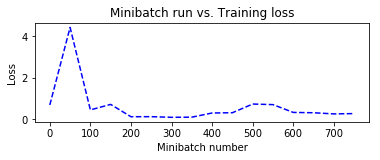

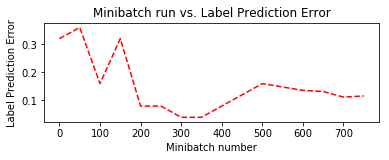

In [21]:
# Compute the moving average loss to smooth out the noise in SGD
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

# Plot the training loss and the training error
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')

plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()

## Evaluation / Testing 

Now that we have trained the network, let us evaluate the trained network on data that hasn't been used for training. This is called **testing**. Let us create some new data and evaluate the average error and loss on this set. This is done using `trainer.test_minibatch`. Note the error on this previously unseen data is comparable to the training error. This is a **key** check. Should the error be larger than the training error by a large margin, it indicates that the trained model will not perform well on data that it has not seen during training. This is known as [overfitting][]. There are several ways to address overfitting that are beyond the scope of this tutorial, but the Cognitive Toolkit provides the necessary components to address overfitting.

Note: we are testing on a single minibatch for illustrative purposes. In practice, one runs several minibatches of test data and reports the average. 

**Question** Why is this suggested? Try plotting the test error over several set of generated data sample and plot using plotting functions used for training. Do you see a pattern?

[overfitting]: https://en.wikipedia.org/wiki/Overfitting


In [22]:
# Run the trained model on a newly generated dataset
test_minibatch_size = 25
features, labels = generate_random_data_sample(test_minibatch_size, input_dim, num_output_classes)

trainer.test_minibatch({feature : features, label : labels}) 

0.12

### Checking prediction / evaluation 
For evaluation, we softmax the output of the network into a probability distribution over the two classes, the probability of each observation being malignant or benign. 

In [23]:
out = C.softmax(z)
result = out.eval({feature : features})

Let us compare the ground-truth label with the predictions. They should be in agreement.

**Question:** 
- How many predictions were mislabeled? Can you change the code below to identify which observations were misclassified? 

In [24]:
print("Label    :", [np.argmax(label) for label in labels])
print("Predicted:", [np.argmax(x) for x in result[0]])

Label    : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]
Predicted: [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]


### Visualization
It is desirable to visualize the results. In this example, the data can be conveniently plotted using two spatial dimensions for the input (patient age on the x-axis and tumor size on the y-axis), and a color dimension for the output (red for malignant and blue for benign). For data with higher dimensions, visualization can be challenging. There are advanced dimensionality reduction techniques, such as [t-sne][] that allow for such visualizations.

[t-sne]: https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

[ 7.99141502 -7.99141407]


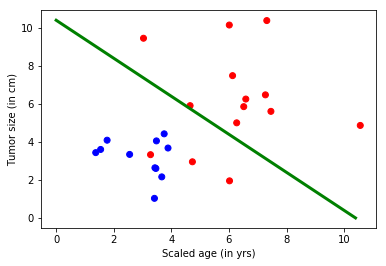

In [25]:
# Model parameters
print(mydict['b'].value)

bias_vector   = mydict['b'].value
weight_matrix = mydict['w'].value

# Plot the data 
import matplotlib.pyplot as plt

# let 0 represent malignant/red, and 1 represent benign/blue
colors = ['r' if label == 0 else 'b' for label in labels[:,0]]
plt.scatter(features[:,0], features[:,1], c=colors)
plt.plot([0, bias_vector[0]/weight_matrix[0][1]], 
         [ bias_vector[1]/weight_matrix[0][0], 0], c = 'g', lw = 3)
plt.xlabel("Patient age (scaled)")
plt.ylabel("Tumor size (in cm)")
plt.show()

**Exploration Suggestions** 
- Try exploring how the classifier behaves with different data distributions - e.g., changing the `minibatch_size` parameter from 25 to 64. Why is the error increasing?
- Try exploring different activation functions
- Try exploring different learners 
- You can explore training a [multiclass logistic regression][] classifier.

[multiclass logistic regression]: https://en.wikipedia.org/wiki/Multinomial_logistic_regression